<a href="https://colab.research.google.com/github/SoumadipDey/Intel-oneAPI-Hackathon/blob/main/Intel_ML_Hackathon_22_03_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Polynomial Regression on Fish Market Dataset to predict weight with respect to features of various species of fish.**

Using the [Intel® Extension for Scikit-learn](https://github.com/intel/scikit-learn-intelex) 

## <b>1<font color = #00C7FD > |</font><font color = #0068B5 >| </font></b>**Priliminary Actions**

**Installing the Intel oneAPI optmized version of sklearn**

In [212]:
!pip install scikit-learn-intelex --quiet

**Importing required packages**

In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression as LinearRegressionSklearn
from sklearnex.linear_model import LinearRegression as LinearRegressionSklearnex
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
sns.set_theme()

**Loading the Dataset**

In [214]:
fish_df = pd.read_csv("https://raw.githubusercontent.com/SoumadipDey/datasets/main/Fish.csv")
print("Shape of Dataframe: ",fish_df.shape)
fish_df.head()

Shape of Dataframe:  (159, 7)


,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


## <b>2<font color = #00C7FD > |</font><font color = #0068B5 >| </font></b>**Data Cleaning**

**Cleaning NaN values if any**



In [215]:
fish_df.isna().sum()

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

**Finding and plotting correlation among the variables**

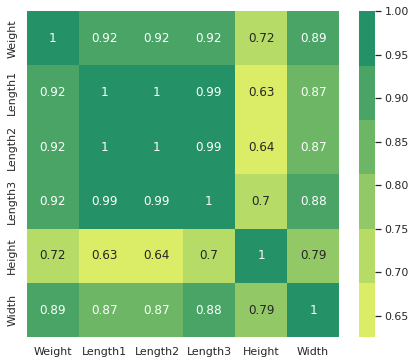

In [216]:
plt.figure(1,(7,6))
sns.heatmap(fish_df.drop(['Species'], axis = 1).corr(),
            annot = True, cmap = sns.color_palette('summer_r'),
)
plt.show()

From the above heatmap, it is clear that the features `Length1`, `Length2`, `Length3` have a very high degree of multicollinearity and thus need to be removed as to not skew the results or overfit the model.

In [217]:
try:
  fish_df.drop(['Length1','Length2','Length3'], axis = 1, inplace = True)
except KeyError:
  print("Length Columns already dropped!")
finally:
  print("Columns:", fish_df.columns.values)

Columns: ['Species' 'Weight' 'Height' 'Width']


**Outlier Detection for various species of Fishes**

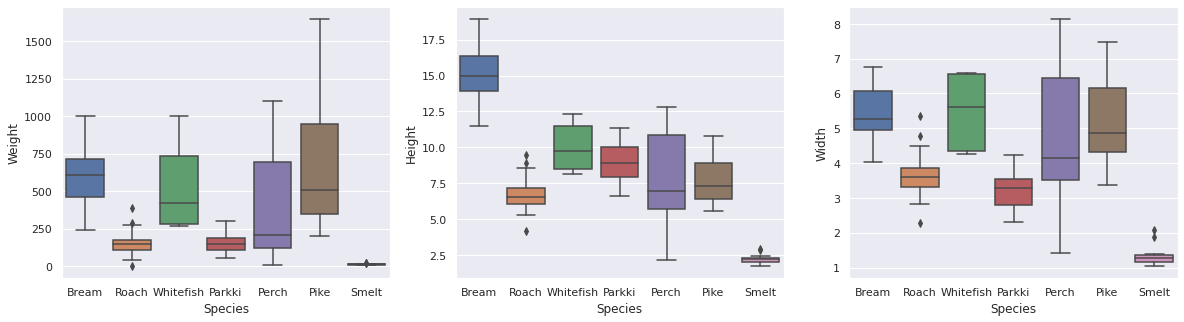

In [218]:
fig , ax = plt.subplots(1,3,figsize = (20,5))
sns.boxplot(data = fish_df, x = 'Species', y = 'Weight', ax = ax[0])
sns.boxplot(data = fish_df, x = 'Species', y = 'Height', ax = ax[1])
sns.boxplot(data = fish_df, x = 'Species', y = 'Width', ax = ax[2])
fig.show()

As we can see from the boxplots, there exist some outliers:


* There are *Weight*, *Height* and *Width* outliers for the Species `Roach`.   
* There are *Weight*, *Height* and *Width* outliers for the Species `Smelt`.



**Finding and removing the outliers**

In [219]:
def findOutliers(dataframe: pd.DataFrame) -> pd.DataFrame:
  Q1 = dataframe.quantile(0.25)
  Q3 = dataframe.quantile(0.75)
  IQR = Q3 - Q1
  upper_end = Q3 + 1.5 * IQR
  lower_end = Q1 - 1.5 * IQR 
  outlier = dataframe[(dataframe > upper_end) | (dataframe < lower_end)]
  return outlier

In [220]:
roach = fish_df.where(fish_df['Species'] == 'Roach').dropna()
smelt = fish_df.where(fish_df['Species'] == 'Smelt').dropna()

In [221]:
outliers = set()
for category in [roach, smelt]:
  for column in category.columns[1:]: 
      outliers.update(findOutliers(category[column]).index.values)

In [222]:
fish_df.drop(list(outliers), inplace = True)

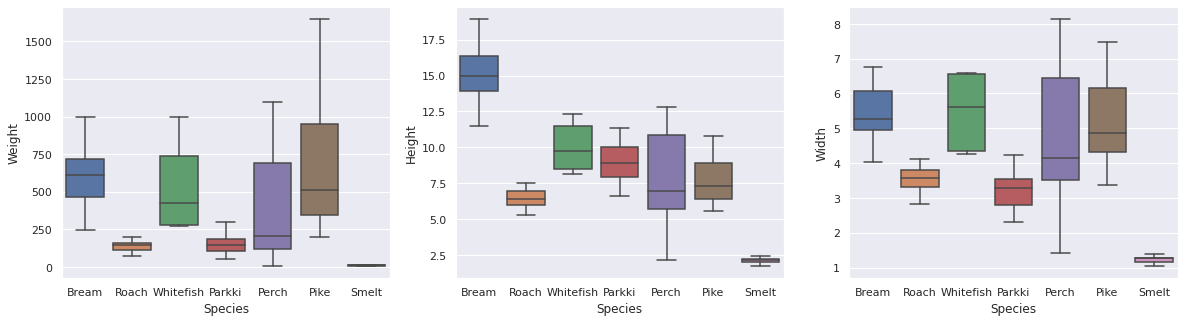

In [223]:
fig , ax = plt.subplots(1,3,figsize = (20,5))
sns.boxplot(data = fish_df, x = 'Species', y = 'Weight', ax = ax[0])
sns.boxplot(data = fish_df, x = 'Species', y = 'Height', ax = ax[1])
sns.boxplot(data = fish_df, x = 'Species', y = 'Width', ax = ax[2])
fig.show()

## <b>3<font color = #00C7FD > |</font><font color = #0068B5 >| </font></b>**Understanding the relationship between the dependent and independent variables**

**Plotting relationships among the numeric variables**

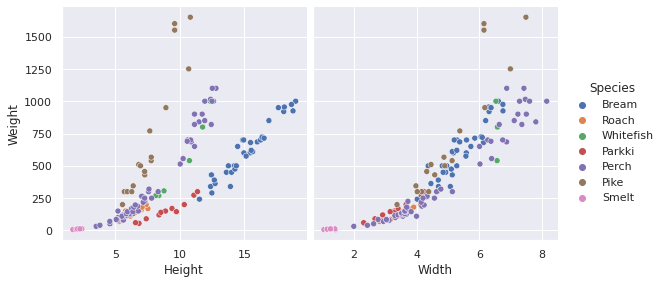

In [224]:
sns.pairplot(data = fish_df, 
             x_vars = fish_df.drop(['Weight','Species'],axis = 1).columns , 
             y_vars = 'Weight', hue = 'Species', height = 4, aspect = 1)
plt.show()

As it can be seen from the pairplot, the independent variables `Width`, `Height` seem to have a polynomial relationship with the dependent variable `Weight`. 

## <b>4<font color = #00C7FD > |</font><font color = #0068B5 >| </font></b>**Data Transformation**

**Scaling The Numerical Values**

In [225]:
ScalerWeight = StandardScaler().fit(fish_df['Weight'].values.reshape(-1,1))
ScalerHeight = StandardScaler().fit(fish_df['Height'].values.reshape(-1,1))
ScalerWidth = StandardScaler().fit(fish_df['Width'].values.reshape(-1,1))

fish_df['Weight'] = ScalerWeight.transform(fish_df['Weight'].values.reshape(-1,1))
fish_df['Height'] = ScalerHeight.transform(fish_df['Height'].values.reshape(-1,1))
fish_df['Width'] = ScalerWidth.transform(fish_df['Width'].values.reshape(-1,1))

**OneHot Encoding the Species**

In [226]:
fish_df = fish_df.join(pd.get_dummies(fish_df.Species, prefix='Species_', drop_first = True))
fish_df.drop(['Species'], axis = 1, inplace = True)
fish_df.head()

,Weight,Height,Width,Species__Parkki,Species__Perch,Species__Pike,Species__Roach,Species__Smelt,Species__Whitefish
0,-0.467215,0.564442,-0.262655,0,0,0,0,0,0
1,-0.333632,0.788249,-0.092851,0,0,0,0,0,0
2,-0.194484,0.764423,0.139323,0,0,0,0,0,0
3,-0.130476,0.846533,-0.003727,0,0,0,0,0,0
4,0.055983,0.779857,0.399678,0,0,0,0,0,0


**Seperating the variables**

In [227]:
X = fish_df.drop(['Weight'], axis = 1).values
y = fish_df['Weight'].values.reshape(-1,1)

In [228]:
print(X.shape,y.shape)

(152, 8) (152, 1)


**Creating Polynomial Features**

In [229]:
X = PolynomialFeatures(degree = 2).fit_transform(X)

## <b>5<font color = #00C7FD > |</font><font color = #0068B5 >| </font></b>**Creating Test and Train Sets**

**Splitting the dataset into training and validation sets**

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 11)

In [231]:
print("Training set dimensions: ",X_train.shape,y_train.shape)
print("Test set dimensions: ",X_test.shape,y_test.shape)

Training set dimensions:  (106, 45) (106, 1)
Test set dimensions:  (46, 45) (46, 1)


## <b>6<font color = #00C7FD > |</font><font color = #0068B5 >| </font></b>**Creating and training the Models**

**Defining a training benchmark function**

In [232]:
def trainAndBench(estimator, X, y, n_executions = 1000):
  times = []
  while len(times) < n_executions:
    model = estimator
    t0 = time.perf_counter()
    model.fit(X, y)
    t1 = time.perf_counter()
    times.append(t1 - t0)

  return np.mean(times), model

**Creating and benchmarking the fit perfromance**

*   Model 1 uses <font color = #F7931E>default sklearn</font> implementation of a LinearRegression estimator.
*   Model 2 uses <font color = #0068B5>Intel optimized sklearnex </font> implementation of a LinearRegression estimator.



In [242]:
mean_time_sklearn, model_1 = trainAndBench(estimator=LinearRegressionSklearn(), X = X_train, y = y_train)
mean_time_sklearnex, model_2 = trainAndBench(estimator=LinearRegressionSklearnex(), X = X_train, y = y_train)
speedup = ((mean_time_sklearn - mean_time_sklearnex) / mean_time_sklearn) * 100
print("The training speedup percentage:", speedup, "%")

The training speedup percentage: 27.40272164338467 %


## <b>7<font color = #00C7FD > |</font><font color = #0068B5 >| </font></b>**Evaluating the models**

**Defining a prediction benchmark function**

In [246]:
def predictAndBench(model, X, n_executions = 1000):
  times = []
  predictions = []
  while len(times) < n_executions:
    t0 = time.perf_counter()
    predictions = model.predict(X)
    t1 = time.perf_counter()
    times.append(t1 - t0)

  return np.mean(times), predictions

**Calculating and benchmarking predictions**

In [248]:
sklearn_mean_predict_time, y_predicted_1 = predictAndBench(model_1, X_test)
sklearnex_mean_predict_time, y_predicted_2 = predictAndBench(model_2, X_test)
speedup = ((sklearn_mean_predict_time - sklearnex_mean_predict_time) / sklearn_mean_predict_time) * 100
print("The prediction speedup percentage:", speedup, "%")

The prediction speedup percentage: 11.910772985536088 %


In [249]:
test_comparison_df = pd.DataFrame({"Actual Weight": ScalerWeight.inverse_transform(y_test).squeeze(),
                                  "Predicted Weight Sklearn":ScalerWeight.inverse_transform(y_predicted_1).squeeze(),
                                  "Predicted Weight Sklearnex":ScalerWeight.inverse_transform(y_predicted_2).squeeze()})
test_comparison_df['Residuals Sklearn'] = test_comparison_df['Actual Weight'] - test_comparison_df['Predicted Weight Sklearn']
test_comparison_df['Residuals Sklearnex'] = test_comparison_df['Actual Weight'] - test_comparison_df['Predicted Weight Sklearnex']
test_comparison_df.head()

,Actual Weight,Predicted Weight Sklearn,Predicted Weight Sklearnex,Residuals Sklearn,Residuals Sklearnex
0,900.0,890.709549,890.709549,9.290451,9.290451
1,40.0,24.615623,24.615623,15.384377,15.384377
2,950.0,1069.873611,1069.873611,-119.873611,-119.873611
3,55.0,72.704495,72.704495,-17.704495,-17.704495
4,510.0,450.080075,450.080075,59.919925,59.919925


**Performance Evaluation through various metrics**

In [250]:
print("For Model 1 (Sklearn)")
print("R2 Score Train:",model_1.score(X_train,y_train))
print("R2 Score Test:",model_1.score(X_test,y_test))
print("MSE Train:",mean_squared_error(y_train,model_1.predict(X_train)))
print("MSE Test:",mean_squared_error(y_test,y_predicted_1))
print("MAPE Train:",mean_absolute_percentage_error(y_train,model_1.predict(X_train))*100,"%")
print("MAPE Test:",mean_absolute_percentage_error(y_test,y_predicted_1)*100,"%")

print("\nFor Model 2 (Sklearnex)")
print("R2 Score Train:",model_2.score(X_train,y_train))
print("R2 Score Test:",model_2.score(X_test,y_test))
print("MSE Train:",mean_squared_error(y_train,model_2.predict(X_train)))
print("MSE Test:",mean_squared_error(y_test,y_predicted_2))
print("MAPE Train:",mean_absolute_percentage_error(y_train,model_2.predict(X_train))*100,"%")
print("MAPE Test:",mean_absolute_percentage_error(y_test,y_predicted_2)*100,"%")

For Model 1 (Sklearn)
R2 Score Train: 0.9561589637167357
R2 Score Test: 0.9781655937950583
MSE Train: 0.04316585411002326
MSE Test: 0.02248207487337898
MAPE Train: 23.843216817134387 %
MAPE Test: 17.970624339853607 %

For Model 2 (Sklearnex)
R2 Score Train: 0.9561589637167357
R2 Score Test: 0.9781655937950583
MSE Train: 0.04316585411002326
MSE Test: 0.02248207487337898
MAPE Train: 23.843216817134387 %
MAPE Test: 17.970624339853607 %


It can be observed that the metrics remain consistent across both the models.

**Histogram of Residuals**

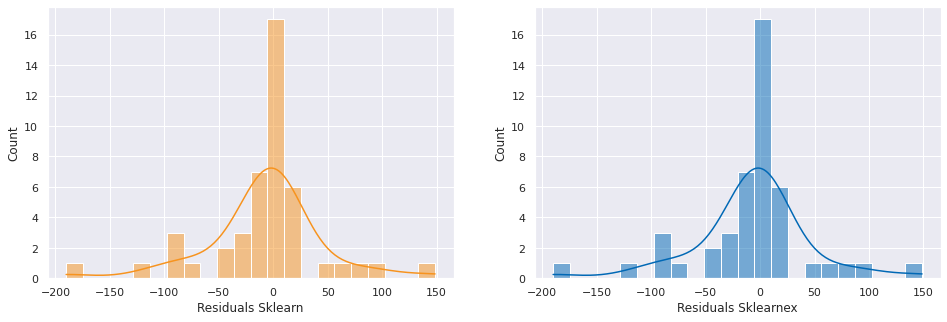

In [253]:
fig,ax = plt.subplots(1,2,figsize = (16,5))
sns.histplot(data = test_comparison_df, x = 'Residuals Sklearn', color = '#F7931E', ax = ax[0], kde = True)
sns.histplot(data = test_comparison_df, x = 'Residuals Sklearnex', color = '#0068B5', ax = ax[1], kde = True)
plt.show()

**Plotting the Predicted Weights against the Actual Weights**

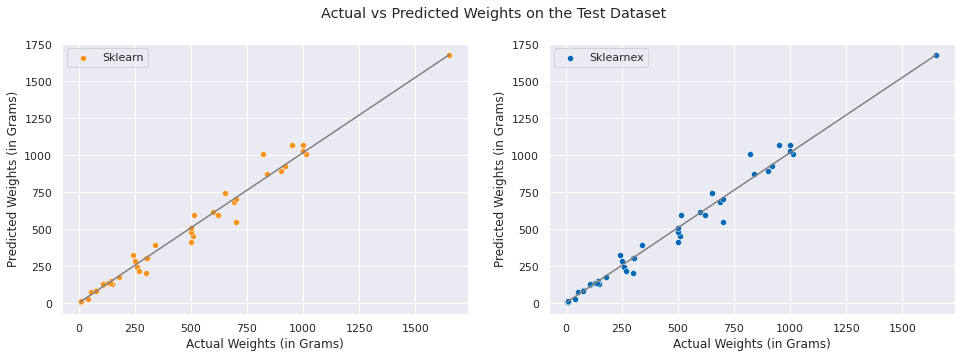

In [256]:
fig, ax = plt.subplots(1,2,figsize = (16,5))
ax[0].set_xlabel("Actual Weights (in Grams)")
ax[0].set_ylabel("Predicted Weights (in Grams)")
fig.suptitle("Actual vs Predicted Weights on the Test Dataset")
sns.scatterplot(data = test_comparison_df, x = 'Actual Weight', y = 'Predicted Weight Sklearn', 
                color = '#F7931E', ax = ax[0], label = 'Sklearn')
sns.scatterplot(data = test_comparison_df, x = 'Actual Weight', y = 'Predicted Weight Sklearnex', 
                color = '#0068B5', ax = ax[1], label = 'Sklearnex')
sns.lineplot(
    x = np.linspace(min(test_comparison_df['Actual Weight']), 
                    max(test_comparison_df['Actual Weight']),
                    num = len(test_comparison_df['Actual Weight'])), 
    y = np.linspace(min(test_comparison_df['Predicted Weight Sklearn']),
                    max(test_comparison_df['Predicted Weight Sklearn']),
                    num = len(test_comparison_df['Predicted Weight Sklearn'])),
    color = 'Grey',
    ax = ax[0]
)
ax[1].set_xlabel("Actual Weights (in Grams)")
ax[1].set_ylabel("Predicted Weights (in Grams)")
sns.lineplot(
    x = np.linspace(min(test_comparison_df['Actual Weight']), 
                    max(test_comparison_df['Actual Weight']),
                    num = len(test_comparison_df['Actual Weight'])), 
    y = np.linspace(min(test_comparison_df['Predicted Weight Sklearn']),
                    max(test_comparison_df['Predicted Weight Sklearn']),
                    num = len(test_comparison_df['Predicted Weight Sklearn'])),
    color = 'Grey',
    ax = ax[1]
)
plt.legend()
plt.show()

**Conclusion**

According to the observations obtained during training and evaluating the models, the Intel® Extension for Scikit-learn enables faster training and predictions while maintaining model performance almost indistinguishable to that of unpatched Sklearn.